# Collate and Process SceanarioMIP data up to 2300 for the Southern Ocean
- 2 Hovmollers: one for the SO south of 40S, the other for the SO south of 63S.
- model runs available to 2300, and for each of the scenarios SSP1-2.6 and SSP5-8.5, is a time vs depth file of the monthly mean ocean temperatures.
- Only needed for depths to 2000m


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path
import os, glob, re

In [2]:
# code to look for models upto 2300
# === Params  ===
BASE      = "/g/data/oi10/replicas/CMIP6/ScenarioMIP"
# INSTITUTE = ""
MODEL = "CESM2-WACCM"
SCENARIO  = "ssp126"    
MEMBER_GLOB = "r1i1p1f1" 
VERSION = "v*"
TAIL      =  "229912.nc"   # 230012 - check model goes to 2300
SAVE_TXT  = ""  # e.g., "/g/data/oi10/ic0706/matches.txt" to save; leave "" to skip
# ===========================

pattern = str(
    Path(BASE) / "*" / MODEL / SCENARIO / MEMBER_GLOB / "Omon" / "thetao" / "gn" / VERSION / f"*{TAIL}"
)
print("Searching pattern:\n", pattern)

matches = []
for p in glob.iglob(pattern):
    if os.path.isfile(p):
        matches.append(os.path.realpath(p))

matches = sorted(matches)

print(f"\nFound {len(matches)} file(s).")
for m in matches:
    print(m)

if SAVE_TXT:
    with open(SAVE_TXT, "w") as f:
        f.write("\n".join(matches))
    print(f"\nSaved {len(matches)} path(s) to: {SAVE_TXT}")

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/CESM2-WACCM/ssp126/r1i1p1f1/Omon/thetao/gn/v*/*229912.nc

Found 1 file(s).
/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp126/r1i1p1f1/Omon/thetao/gn/v20210211/thetao_Omon_CESM2-WACCM_ssp126_r1i1p1f1_gn_225101-229912.nc


### Functions 
1. find files in oi10
2. mask southern ocean
3. find weighted mean

In [5]:
def find_files(model, version, scenario):
    # === Params  ===
    BASE      = "/g/data/oi10/replicas/CMIP6/ScenarioMIP"
    # INSTITUTE = ""
    MODEL = model
    SCENARIO  =scenario    
    MEMBER_GLOB = "r1i1p1f1" 
    VERSION = version
    # ================
    
    pattern = str(
        Path(BASE) / "*" / MODEL / SCENARIO / MEMBER_GLOB / "Omon" / "thetao" / "gn" / VERSION / "*"
    )
    print("Searching pattern:\n", pattern)
    
    matches = []
    for p in glob.iglob(pattern):
        if os.path.isfile(p):
            matches.append(os.path.realpath(p))
    
    matches = sorted(matches)
    return matches


In [60]:
def mask_SO(lat, data, model):

    if model in ['CanESM5','UKESM']:
        southern2d = (data['latitude'] <= lat).persist()

        j_sel = southern2d.any('i').compute()  
        i_sel = southern2d.any('j').compute()  

        SO = data.isel(j=j_sel, i=i_sel)
        SO = SO.where(data['latitude'].isel(j=j_sel, i=i_sel) <= lat)
        return SO

    elif model == 'IPSL':
        southern2d = (data['nav_lat'] <= lat).persist()

        y_sel = southern2d.any('x').compute()  
        x_sel = southern2d.any('y').compute() 

        SO = data.isel(y=y_sel, x=x_sel)
        SO = SO.where(data['nav_lat'].isel(y=y_sel, x=x_sel) <= lat)
        return SO
        
    elif model == 'MRI':
        southern2d = (data['latitude'] <= lat).persist()

        y_sel = southern2d.any('x').compute()  
        x_sel = southern2d.any('y').compute() 

        SO = data.isel(y=y_sel, x=x_sel)
        SO = SO.where(data['latitude'].isel(y=y_sel, x=x_sel) <= lat)
        return SO
    elif model =='CESM2':
        
        southern2d = (data['lat'] <= lat)           # (nlat, nlon) bool
        
        # selectors with correct shapes
        nlat_sel = southern2d.any(dim='nlon').compute()  # (nlat=384) bool (now NumPy)
        nlon_sel = southern2d.any(dim='nlat').compute()  # (nlon=320) bool (now NumPy)
        
        SO = data.isel(nlat=nlat_sel, nlon=nlon_sel)
        SO = SO.where(data['lat'].isel(nlat=nlat_sel, nlon=nlon_sel) <= lat)
        return SO
        
        
    else:
        raise ValueError(f"Unknown model '{model}'. Expected 'CanESM5', 'IPSL' or 'MRI'.")



In [61]:
def weighted_SO_area_mean(lat,data,areacello,model):
    data_SO = mask_SO(lat,data,model)
    print('masked thetao data')
    areacello_SO = mask_SO(lat,areacello,model)
    print('masked areacello')
    
    if model in ['CanESM5','UKESM']:
        data_area_mean = data_SO.thetao.weighted(
            areacello_SO.areacello.broadcast_like(data_SO.thetao).fillna(0)
        ).mean(('j','i'))
        print('weighted mean found')

    elif model in ['IPSL', 'MRI']: 
        data_area_mean = data_SO.thetao.weighted(
            areacello_SO.areacello.broadcast_like(data_SO.thetao).fillna(0)
        ).mean(('y','x'))
        print('weighted mean found')
        
    elif model == 'CESM2': 
        data_area_mean = data_SO.thetao.weighted(
            areacello_SO.areacello.broadcast_like(data_SO.thetao).fillna(0)
        ).mean(('nlon','nlat'))
        print('weighted mean found')
        
    else:
        print('model not recognised')

    if lat == -40:
        data_area_mean = (data_area_mean.rename('thetao_40S_area_mean').assign_attrs({
            'long_name': 'Southern Ocean 40S area-mean potential temperature',
            'description': 'Area-weighted mean south of 40S on native grid (weights=areacello)',
            'units': data.thetao.attrs.get('units', 'K'),
            'cell_methods': 'j,i: mean (weighted by areacello); time: point; lev: point',
            'region': 'south_of_40S' 
        })
                               )
        print('40S attributes assigned')

    else: 
        data_area_mean = (data_area_mean.rename('thetao_63S_area_mean').assign_attrs({
            'long_name': 'Southern Ocean 63S area-mean potential temperature',
            'description': 'Area-weighted mean south of 63S on native grid (weights=areacello)',
            'units': data.thetao.attrs.get('units', 'K'),
            'cell_methods': 'j,i: mean (weighted by areacello); time: point; lev: point',
            'region': 'south_of_63S' 
        })
                               )
        print('63S attributes assigned')
    return data_area_mean

## CanESM5

In [62]:
# load areacello file for CanESM5 
# search pattern to find this file is at the bottom of the notebook 
CanESM5_areacello = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_piControl_r1i1p1f1_gn.nc')

#### ssp126

In [55]:
matches = find_files("CanESM5","v20190429","ssp126") # find files
# load datasets - for canESM5 slice at 2100 so that when interpolate is done later on there's no nans
CanESM5_glob_ssp126 = xr.open_mfdataset(matches, combine='by_coords').sel(lev = slice(0,2100))
CanESM5_glob_ssp126

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/CanESM5/ssp126/r1i1p1f1/Omon/thetao/gn/v20190429/*


<xarray.Dataset> Size: 66GB
Dimensions:             (time: 3432, bnds: 2, lev: 30, j: 291, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16...
  * lev                 (lev) float64 240B 3.047 9.454 ... 1.85e+03 2.054e+03
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 838kB dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 838kB dask.array<chunksize=(291, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 55kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 2MB dask.array<chunksize=(72, 30, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 12GB dask.array<chunksize=(72, 291, 360, 2), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float64 12GB dask.array<chunksize=(72, 291, 360, 2), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 43GB dask.array<chunksize=(1, 21, 145, 109), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            1f91f92cb6d607391f44831504025d32fc44faa1
    CCCma_parent_runid:          rc3.1-his01
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-s2601
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    variable_id:                 thetao
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0
    tracking_id:                 hdl:21.14100/c6d88951-77c4-4a6a-9b0b-2c10390...

In [58]:
CanESM5_40S_area_mean = weighted_SO_area_mean(-40,CanESM5_glob_ssp126,CanESM5_areacello,'CanESM5')
print('40S done')
CanESM5_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc')
print('40S saved')
CanESM5_40S_area_mean.close() # clear up some mem
### 
CanESM5_63S_area_mean = weighted_SO_area_mean(-63,CanESM5_glob_ssp126,CanESM5_areacello,'CanESM5')
print('63S done')
CanESM5_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc')
print('63S saved')

masked thetao data
masked areacello
weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
weighted mean found
63S attributes assigned
63S done
63S saved


## sanity check

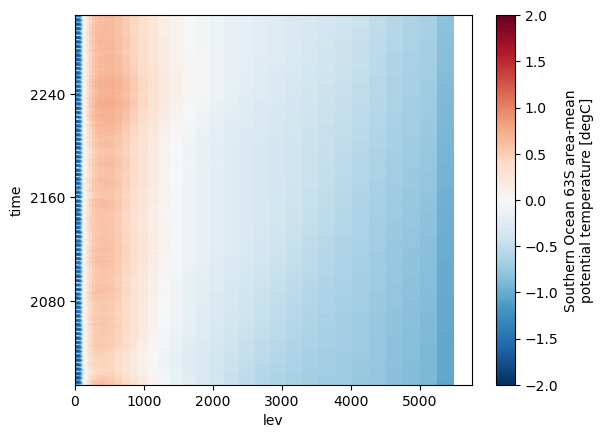

In [56]:
CanESM5_63S_area_mean = xr.open_dataset('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc')
CanESM5_63S_area_mean.thetao_63S_area_mean.sel(lev = slice(0,2100)).plot(cmap = 'RdBu_r', vmin =-2, vmax = 2)
# looks fine

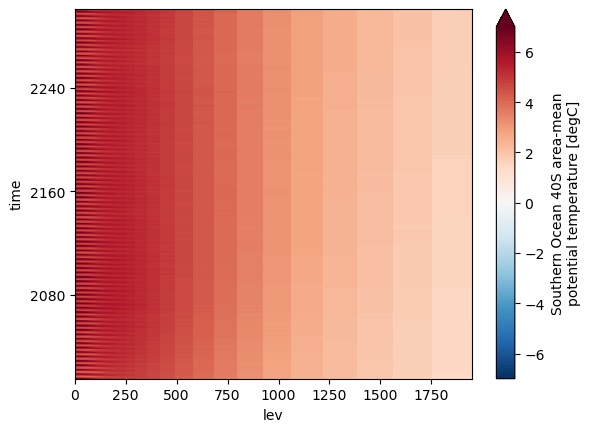

In [20]:
CanESM5_40S_area_mean = xr.open_dataset('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc')
CanESM5_40S_area_mean.thetao_40S_area_mean.sel(lev = slice(0,2100)).plot(cmap = 'RdBu_r', vmin =-7, vmax = 7)

### ssp585

In [59]:
matches = find_files("CanESM5","v20190429","ssp585")
CanESM5_glob_ssp585 = xr.open_mfdataset(matches, combine='by_coords').sel(lev = slice(0,2100))
print('opened datasets')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/CanESM5/ssp585/r1i1p1f1/Omon/thetao/gn/v20190429/*
opened datasets


In [60]:
CanESM5_40S_area_mean = weighted_SO_area_mean(-40,CanESM5_glob_ssp585,CanESM5_areacello,'CanESM5')
print('40S done')
CanESM5_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CanESM5_ssp585_r1i1p1f1_201501-230012.nc')
print('40S saved')
CanESM5_40S_area_mean.close() # clear up some mem
### 
CanESM5_63S_area_mean = weighted_SO_area_mean(-63,CanESM5_glob_ssp585,CanESM5_areacello,'CanESM5')
print('63S done')
CanESM5_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_CanESM5_ssp585_r1i1p1f1_201501-230012.nc')
print('63S saved')

masked thetao data
masked areacello
weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
weighted mean found
63S attributes assigned
63S done
63S saved


## IPSL-CM6A-LR

In [5]:
# area data varaible avaliable in file 
IPSL_areacello = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/areacello/gn/v20200326/areacello_Ofx_IPSL-CM6A-LR_piControl_r1i1p1f1_gn.nc')

#### ssp126

In [5]:
matches = find_files("IPSL-CM6A-LR","v*","ssp126")
IPSL_glob_ssp126 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True).rename({'olevel':'lev'}).sel(lev = slice(0,2000))
# IPSL_glob_ssp126

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/IPSL-CM6A-LR/ssp126/r1i1p1f1/Omon/thetao/gn/v*/*


<xarray.Dataset> Size: 104GB
Dimensions:         (time: 3432, y: 332, x: 362, nvertex: 4, lev: 54,
                     axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
  * lev             (lev) float32 216B 0.5058 1.556 ... 1.796e+03 1.945e+03
  * time            (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (time, y, x, nvertex) float32 7GB dask.array<chunksize=(1032, 332, 362, 4), meta=np.ndarray>
    bounds_nav_lat  (time, y, x, nvertex) float32 7GB dask.array<chunksize=(1032, 332, 362, 4), meta=np.ndarray>
    area            (time, y, x) float32 2GB dask.array<chunksize=(1032, 332, 362), meta=np.ndarray>
    olevel_bounds   (time, lev, axis_nbounds) float32 1MB dask.array<chunksize=(1032, 54, 2), meta=np.ndarray>
    time_bounds     (time, axis_nbounds) object 55kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    thetao          (time, lev, y, x) float32 89GB dask.array<chunksize=(1, 54, 332, 362), meta=np.ndarray>
Attributes: (12/51)
    name:                   /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/IPSL...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-12-18T21:01:59Z
    tracking_id:            hdl:21.14100/2dcb0cf9-ff34-48b6-97c6-c63ed2cdfbbd
    description:            Future scenario with low radiative forcing by the...
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / Sc...
    ...                     ...
    variant_info:           Each member starts from the corresponding member ...
    variant_label:          r1i1p1f1
    EXPID:                  ssp126
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          c2dce418e78ca835be1e2ff817c2c403
    model_version:          6.1.8

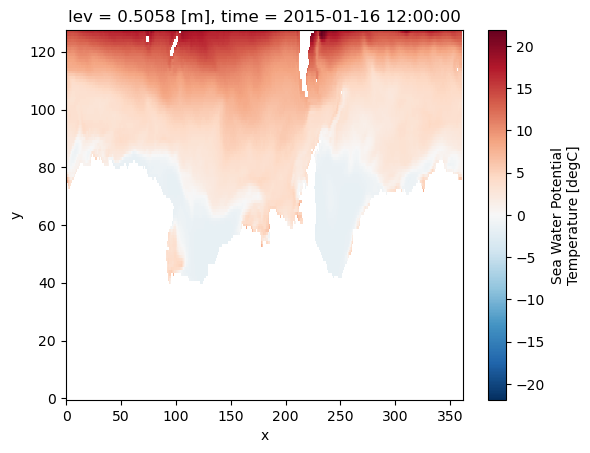

In [46]:
#check mask is okay
IPSL_glob_ssp126_SO = mask_SO(-40,IPSL_glob_ssp126,'IPSL')
IPSL_glob_ssp126_SO.thetao.isel(time = 0, lev=0).plot()

In [ ]:
IPSL_40S_area_mean = weighted_SO_area_mean(-40,IPSL_glob_ssp126,IPSL_areacello, 'IPSL')
print('40S done')
IPSL_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc')
print('40S saved')
del IPSL_40S_area_mean # clear up some mem
### 
IPSL_63S_area_mean = weighted_SO_area_mean(-63,IPSL_glob_ssp126,IPSL_areacello, 'IPSL')
print('63S done')
IPSL_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc')
print('63S saved')

masked thetao data
masked areacello
ipsl if statement


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/array/einsumfuncs.py:272: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/array/einsumfuncs.py:272: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
ipsl if statement


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/array/einsumfuncs.py:272: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/array/einsumfuncs.py:272: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


weighted mean found
63S attributes assigned
63S done


#### ssp585

In [6]:
matches = find_files("IPSL-CM6A-LR","v*","ssp585")
IPSL_glob_ssp585 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True).rename({'olevel':'lev'}).sel(lev = slice(0,2000))
print('opened datasets')

IPSL_40S_area_mean = weighted_SO_area_mean(-40,IPSL_glob_ssp585,IPSL_areacello,'IPSL')
print('40S done')
IPSL_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp585_r1i1p1f1_201501-230012.nc')
print('40S saved')
IPSL_40S_area_mean.close() # clear up some mem
### 
IPSL_63S_area_mean = weighted_SO_area_mean(-63,IPSL_glob_ssp585,IPSL_areacello,'IPSL')
print('63S done')
IPSL_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_IPSL-CM6A-LR_ssp585_r1i1p1f1_201501-230012.nc')
print('63S saved')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/IPSL-CM6A-LR/ssp585/r1i1p1f1/Omon/thetao/gn/v*/*
opened datasets
masked thetao data
masked areacello


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/array/einsumfuncs.py:272: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/array/einsumfuncs.py:272: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


weighted mean found
63S attributes assigned
63S done
63S saved


## MRI-ESM2-0

In [47]:
MRI_areacello = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/MRI/MRI-ESM2-0/piControl/r1i1p1f1/Ofx/areacello/gn/v20191224/areacello_Ofx_MRI-ESM2-0_piControl_r1i1p1f1_gn.nc')

In [49]:
MRI_areacello.areacello

<xarray.DataArray 'areacello' (y: 363, x: 360)> Size: 523kB
[130680 values with dtype=float32]
Coordinates:
  * y          (y) float64 3kB -78.0 -77.5 -77.0 -76.5 ... 149.7 151.8 154.0
  * x          (x) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    latitude   (y, x) float64 1MB ...
    longitude  (y, x) float64 1MB ...
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        Horizontal area of ocean grid cells
    units:          m2
    cell_methods:   area: sum
    history:        2019-12-05T01:22:16Z altered by CMOR: replaced missing va...

#### ssp126

In [27]:
matches = find_files("MRI-ESM2-0","v20210329","ssp126")
MRI_glob_ssp126 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True)
print('opened dataset')

MRI_40S_area_mean = weighted_SO_area_mean(-40,MRI_glob_ssp126,MRI_areacello,'MRI')
print('40S done')
MRI_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_201501-230012.nc')
print('40S saved')
del MRI_40S_area_mean # clear up some mem
### 
MRI_63S_area_mean = weighted_SO_area_mean(-63,MRI_glob_ssp126,MRI_areacello,'MRI')
print('63S done')
MRI_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_201501-230012.nc')
print('63S saved')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/MRI-ESM2-0/ssp126/r1i1p1f1/Omon/thetao/gn/v20210329/*
opened dataset
masked thetao data
masked areacello
mri stream
weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
mri stream
weighted mean found
63S attributes assigned
63S done
63S saved


#### ssp585

In [27]:
matches = find_files("MRI-ESM2-0","v*","ssp585")
MRI_glob_ssp585 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True)
print('opened datasets')

MRI_40S_area_mean = weighted_SO_area_mean(-40,MRI_glob_ssp585,MRI_areacello,'MRI')
print('40S done')
MRI_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_201501-230012.nc')
print('40S saved')
MRI_40S_area_mean.close() # clear up some mem
### 
MRI_63S_area_mean = weighted_SO_area_mean(-63,MRI_glob_ssp585,MRI_areacello,'MRI')
print('63S done')
MRI_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_201501-230012.nc')
print('63S saved')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/MRI-ESM2-0/ssp585/r1i1p1f1/Omon/thetao/gn/v*/*
opened datasets
masked thetao data
masked areacello
weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
weighted mean found
63S attributes assigned
63S done
63S saved


## CESM2-WACCM 

In [4]:
CESM2_areacello = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2-WACCM/piControl/r1i1p1f1/Ofx/areacello/gn/v20190320/areacello_Ofx_CESM2-WACCM_piControl_r1i1p1f1_gn.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [50]:
CESM2_areacello.areacello.transpose()

<xarray.DataArray 'areacello' (nlon: 320, nlat: 384)> Size: 492kB
[122880 values with dtype=float32]
Coordinates:
    lat      (nlon, nlat) float64 983kB ...
    lon      (nlon, nlat) float64 983kB ...
  * nlat     (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
Attributes: (12/17)
    cell_methods:   area: sum
    comment:        Cell areas for any grid used to report ocean variables an...
    description:    Cell areas for any grid used to report ocean variables an...
    frequency:      fx
    id:             areacello
    long_name:      Grid-Cell Area for Ocean Variables
    ...             ...
    time_label:     None
    time_title:     No temporal dimensions ... fixed field
    title:          Grid-Cell Area for Ocean Variables
    type:           real
    units:          m2
    variable_id:    areacello

#### ssp126

In [66]:
matches = find_files("CESM2-WACCM","v*","ssp126")
CESM2_glob_ssp126 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True)
# this model actually uses cm as units for depth -- unreal, convert to m like normal
CESM2_glob_ssp126['lev'] = CESM2_glob_ssp126['lev'] / 100.0
CESM2_glob_ssp126.lev.attrs = {
    'axis': 'Z',
    'bounds': 'lev_bnds',
    'positive': 'down',
    'standard_name': 'olevel',
    'title': 'ocean model level',
    'type': 'double',
    'units': 'm',
}
CESM2_glob_ssp126 = CESM2_glob_ssp126.sel(lev = slice(0,2200))
print('opened dataset')

CESM2_40S_area_mean = weighted_SO_area_mean(-40,CESM2_glob_ssp126,CESM2_areacello,'CESM2')
print('40S done')
CESM2_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-229912.nc')
print('40S saved')
del CESM2_40S_area_mean # clear up some mem
## 
CESM2_63S_area_mean = weighted_SO_area_mean(-63,CESM2_glob_ssp126,CESM2_areacello,'CESM2')
print('63S done')
CESM2_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-229912.nc')
print('63S saved')

masked thetao data
masked areacello
weighted mean found
63S attributes assigned
63S done
63S saved


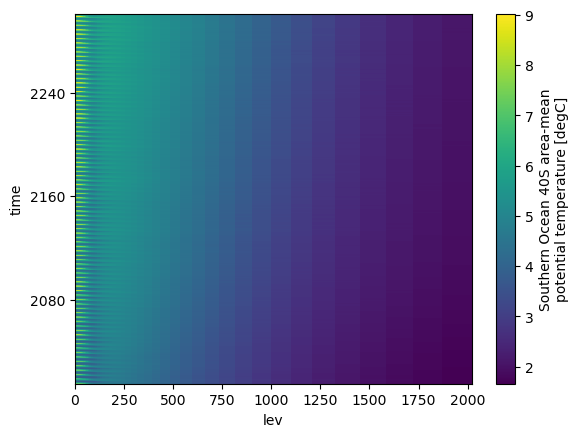

In [82]:
test  = xr.open_dataset('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/collated/MRI-ESM2-0.nc',use_cftime=True)
test.thetao_40S_ssp126.plot()

#### ssp585

In [68]:
matches = find_files("CESM2-WACCM","v*","ssp585")
CESM2_glob_ssp585 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True)
# convert to m 
CESM2_glob_ssp585['lev'] = CESM2_glob_ssp585['lev'] / 100.0
CESM2_glob_ssp585.lev.attrs = {
    'axis': 'Z',
    'bounds': 'lev_bnds',
    'positive': 'down',
    'standard_name': 'olevel',
    'title': 'ocean model level',
    'type': 'double',
    'units': 'm',
}
CESM2_glob_ssp585 = CESM2_glob_ssp585.sel(lev = slice(0,2200))
print('opened dataset')

CESM2_40S_area_mean = weighted_SO_area_mean(-40,CESM2_glob_ssp585,CESM2_areacello,'CESM2')
print('40S done')
CESM2_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp585_r1i1p1f1_201501-229912.nc')
print('40S saved')
del CESM2_40S_area_mean # clear up some mem
### 
CESM2_63S_area_mean = weighted_SO_area_mean(-63,CESM2_glob_ssp585,CESM2_areacello,'CESM2')
print('63S done')
CESM2_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_CESM2-WACCM_ssp585_r1i1p1f1_201501-229912.nc')
print('63S saved')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/CESM2-WACCM/ssp585/r1i1p1f1/Omon/thetao/gn/v*/*


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20} defined, d

opened dataset
masked thetao data
masked areacello
weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
weighted mean found
63S attributes assigned
63S done
63S saved


##  UKESM1-0-LL -tbd

In [6]:
UKESM_areacello = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Ofx/areacello/gn/v20190705/areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')

#### ssp126

In [7]:
# file list -  /g/data/e14/ic0706
# code to look for models upto 2300
# g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/thetao_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_gn_225001-229912.nc
# === Params  ===
BASE      = "/g/data/oi10/replicas/CMIP6/ScenarioMIP"
# INSTITUTE = ""
MODEL = "UKESM1-0-LL"
SCENARIO  = "ssp126"    
MEMBER_GLOB = "r4i1p1f2" 
VERSION = "v20211202"
TAIL      =  "*.nc"   # 230012 - check model goes to 2300
SAVE_TXT  = ""  # e.g., "/g/data/oi10/ic0706/matches.txt" to save; leave "" to skip
# ===========================

pattern = str(
    Path(BASE) / "*" / MODEL / SCENARIO / MEMBER_GLOB / "Omon" / "thetao" / "gn" / VERSION / f"*{TAIL}"
)
print("Searching pattern:\n", pattern)

matches = []
for p in glob.iglob(pattern):
    if os.path.isfile(p):
        matches.append(os.path.realpath(p))

matches = sorted(matches)

print(f"\nFound {len(matches)} file(s).")
for m in matches:
    print(m)

# if SAVE_TXT:
#     with open(SAVE_TXT, "w") as f:
#         f.write("\n".join(matches))
#     print(f"\nSaved {len(matches)} path(s) to: {SAVE_TXT}")
# matches

UKESM_glob_ssp126 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True).sel(lev = slice(0,2000))
print('opened datasets')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/**.nc

Found 4 file(s).
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/thetao_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_gn_201501-204912.nc
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/thetao_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_gn_205001-209912.nc
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/thetao_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_gn_215001-219912.nc
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/thetao_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_gn_225001-229912.nc
opened datasets


In [8]:
UKESM_40S_area_mean = weighted_SO_area_mean(-40,UKESM_glob_ssp126,UKESM_areacello,'UKESM')
print('40S done')
UKESM_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_201501-229912.nc')
print('40S saved')
UKESM_40S_area_mean.close() # clear up some mem
### 
UKESM_63S_area_mean = weighted_SO_area_mean(-63,UKESM_glob_ssp126,UKESM_areacello,'UKESM')
print('63S done')
UKESM_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_201501-229912.nc')
print('63S saved')

masked thetao data
masked areacello
weighted mean found
40S attributes assigned
40S done
40S saved
masked thetao data
masked areacello
weighted mean found
63S attributes assigned
63S done
63S saved


#### ssp585

In [19]:
# file list - part in /g/data/oi10/ part in /g/data/e14/ic0706

# file list - part in /g/data/oi10/ part in /g/data/e14/ic0706
# code to look for models upto 2300
# g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r4i1p1f2/Omon/thetao/gn/v20211202/thetao_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_gn_225001-229912.nc
# === Params  ===
BASE      = "/g/data/oi10/replicas/CMIP6/ScenarioMIP"
# INSTITUTE = ""
MODEL = "UKESM1-0-LL"
SCENARIO  = "ssp585"    
MEMBER_GLOB = "*" 
VERSION = "v*"
TAIL      =  "*.nc"   # 230012 - check model goes to 2300
SAVE_TXT  = ""  # e.g., "/g/data/oi10/ic0706/matches.txt" to save; leave "" to skip
# ===========================

pattern = str(
    Path(BASE) / "*" / MODEL / SCENARIO / MEMBER_GLOB / "Omon" / "thetao" / "gn" / VERSION / f"*{TAIL}"
)
print("Searching pattern:\n", pattern)

matches = []
for p in glob.iglob(pattern):
    if os.path.isfile(p):
        matches.append(os.path.realpath(p))

matches = sorted(matches)

print(f"\nFound {len(matches)} file(s).")
for m in matches:
    print(m)

# if SAVE_TXT:
#     with open(SAVE_TXT, "w") as f:
#         f.write("\n".join(matches))
#     print(f"\nSaved {len(matches)} path(s) to: {SAVE_TXT}")
# matches

# UKESM_glob_ssp585 = xr.open_mfdataset(matches, combine='by_coords',use_cftime=True).sel(lev = slice(0,2000))
# print('opened datasets')

Searching pattern:
 /g/data/oi10/replicas/CMIP6/ScenarioMIP/*/UKESM1-0-LL/ssp585/*/Omon/thetao/gn/v*/**.nc

Found 3 file(s).
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Omon/thetao/gn/v20190726/thetao_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Omon/thetao/gn/v20190726/thetao_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-209912.nc
/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Omon/thetao/gn/v20190726/thetao_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_210001-210012.nc


In [ ]:
UKESM_40S_area_mean = weighted_SO_area_mean(-40,UKESM_glob_ssp585,UKESM_areacello,'UKESM')
print('40S done')
UKESM_40S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_201501-229912.nc')
print('40S saved')
UKESM_40S_area_mean.close() # clear up some mem
### 
UKESM_63S_area_mean = weighted_SO_area_mean(-63,UKESM_glob_ssp585,UKESM_areacello,'UKESM')
print('63S done')
UKESM_63S_area_mean.to_netcdf('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_63S_area_mean_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_201501-229912.nc')
print('63S saved')

# Some plots as a sanity check

In [ ]:
CanESM_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc')
IPSL_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc')
MRI_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_201501-230012.nc')
CESM2_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-229912.nc')
# UKESM_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_UKESM1-0-LL_ssp126_r4i1p1f2_201501-229912.nc')

datasets = [('CanESM5', CanESM_40Sssp126), ('IPSL-CM6A-LR', IPSL_40Sssp126), ('MRI-ESM2-0', MRI_40Sssp126), ('CESM2',CESM2_40Sssp126)]
#,('UKESM1-0-LL',UKESM_40Sssp126)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True, sharey=True)

for ax, (name, ds) in zip(axes, datasets):
    ds.sel(lev=slice(100, 2000)).plot(
        x='time', y='lev', ax=ax, cmap='viridis', add_colorbar=True,vmin = 0, vmax = 5.5
    )
    ax.set_title(name)
    ax.invert_yaxis()



## Need to interpolate to the same levs - choose IPSL lev since it ends exactly at 2000.

***NB# Plots interpolated to the same 'lev' will be in lev_regrid***


In [69]:
# interpolate levels of all files in ScenarioMIP_SO and interpolate levels (depth) to be the same as IPSL
ref = '/g/data/e14/ic0706/ScenarioMIP_SO/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc'
ipsl_lev = xr.open_dataset(ref,use_cftime=True).lev.values # reference dataset

in_dir  = '/g/data/e14/ic0706/ScenarioMIP_SO'
out_dir = '/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid' #make a new folder - datasets will have the same name as before
os.makedirs(out_dir, exist_ok=True)

files = sorted(glob.glob(os.path.join(in_dir, '*.nc')))

for f in files:
    with xr.open_dataset(f,use_cftime=True) as ds:
        ds2 = ds.sortby('lev').interp(lev=ipsl_lev)  # interpolate
        out_path = os.path.join(out_dir, os.path.basename(f))
        tmp = out_path + '.tmp'
        ds2.to_netcdf(tmp, mode='w') # make sure files can be overwritten if run again
    os.replace(tmp, out_path)
    print('wrote', out_path)


wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-229912.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-230012.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp585_r1i1p1f1_201501-229912.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CanESM5_ssp585_r1i1p1f1_201501-230012.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp585_r1i1p1f1_201501-230012.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_201501-230012.nc
wrote /g/data/e14/ic0706/Scenar

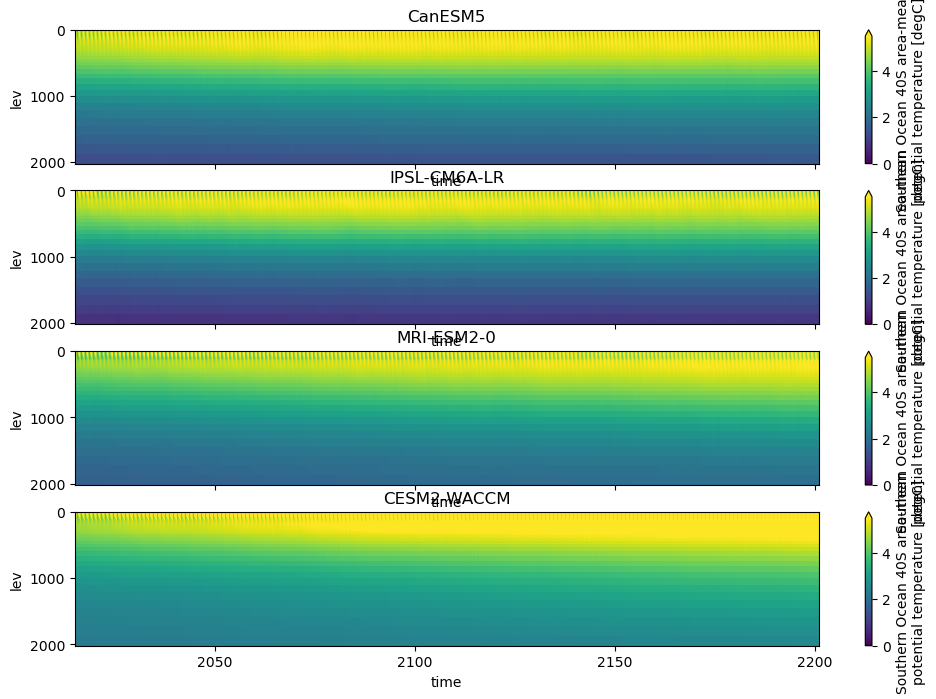

In [71]:
# check

CanESM_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc',use_cftime=True)
IPSL_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc',use_cftime=True)
MRI_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_201501-230012.nc',use_cftime=True)
CESM2_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-229912.nc',use_cftime=True)

datasets = [('CanESM5', CanESM_40Sssp126), ('IPSL-CM6A-LR', IPSL_40Sssp126), ('MRI-ESM2-0', MRI_40Sssp126), ('CESM2-WACCM',CESM2_40Sssp126)]

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True, sharey=True)

for ax, (name, ds) in zip(axes, datasets):
    ds.sel(lev=slice(0, 2000)).sel(time = slice('2015','2200')).plot(
        x='time', y='lev', ax=ax, cmap='viridis', add_colorbar=True,vmin = 0, vmax = 5.5
    )
    ax.set_title(name)
    ax.invert_yaxis()


noice

#### Have one file per model 

In [73]:
# create 1 dataset per model 

from pathlib import Path
from collections import defaultdict
import xarray as xr

ROOT = Path("/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid")
OUT = ROOT / "collated"
OUT.mkdir(exist_ok=True)

files = sorted(ROOT.glob("thetao_*_area_mean_Omon_*_ssp*.nc"))

by_model = defaultdict(list)
for f in files:
    parts = f.name.split("_")
    # name pattern: thetao_{BAND}_area_mean_Omon_{MODEL}_{SSP}_r..._.nc
    band  = parts[1]           # e.g., "40S" or "63S"
    model = parts[5]           # e.g., "CanESM5", "IPSL-CM6A-LR"
    ssp   = parts[6]           # e.g., "ssp126", "ssp585"
    var   = f"thetao_{band}_{ssp}"
    by_model[model].append((var, f))

for model, items in by_model.items():
    ds_list = []
    for var, f in items:
        da = xr.open_dataarray(f, chunks="auto",use_cftime=True)
        ds_list.append(da.to_dataset(name=var))
    ds = xr.merge(ds_list, combine_attrs="override")
    out = OUT / f"{model}.nc"
    ds.to_netcdf(out)
    print("wrote", out)


wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/collated/CESM2-WACCM.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/collated/CanESM5.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/collated/IPSL-CM6A-LR.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/collated/MRI-ESM2-0.nc
wrote /g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/collated/UKESM1-0-LL.nc


# Find anomalies 

just procrastinating now - go do work

In [74]:
def find_anoms(data):
    clim = data.groupby('time.month').mean('time')
    anom = (data.groupby('time.month') - clim).rename('thetao_anom')
    return anom

In [75]:
CanESM_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CanESM5_ssp126_r1i1p1f1_201501-230012.nc',use_cftime=True)
IPSL_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_201501-230012.nc',use_cftime=True)
MRI_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_201501-230012.nc',use_cftime=True)
CESM2_40Sssp126= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp126_r1i1p1f1_201501-229912.nc',use_cftime=True)

datasets = [('CanESM5', find_anoms(CanESM_40Sssp126)), ('IPSL-CM6A-LR', find_anoms(IPSL_40Sssp126)), ('MRI-ESM2-0', find_anoms(MRI_40Sssp126)),('CESM2-WACCM',find_anoms(CESM2_40Sssp126))]

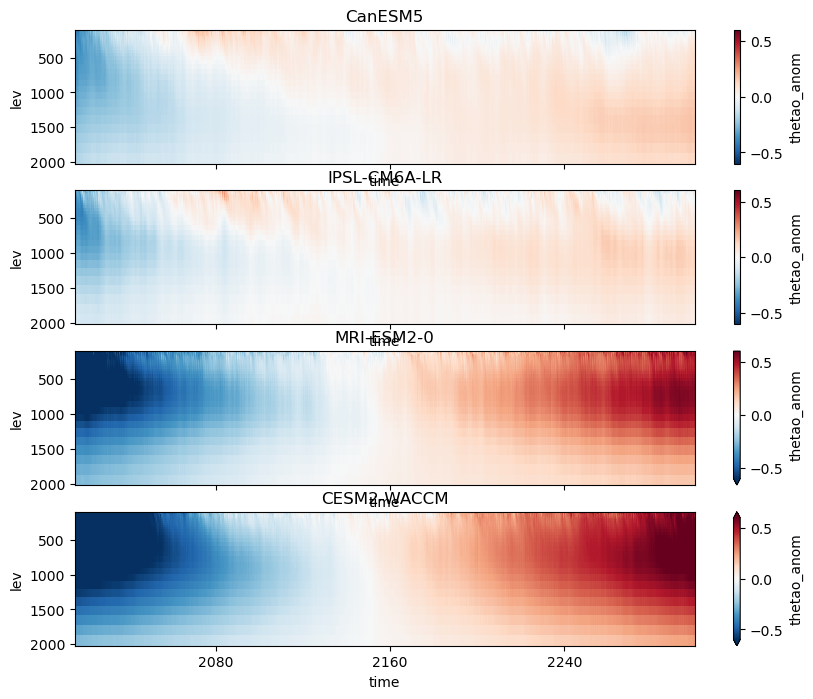

In [76]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)

for ax, (name, ds) in zip(axes, datasets):
    ds.sel(lev=slice(100, 2000)).sel(time = slice('2015','2300')).plot(
        x='time', y='lev', ax=ax, cmap='RdBu_r', add_colorbar=True,vmin = -0.6, vmax = 0.6
    )
    ax.set_title(name)
    ax.invert_yaxis()

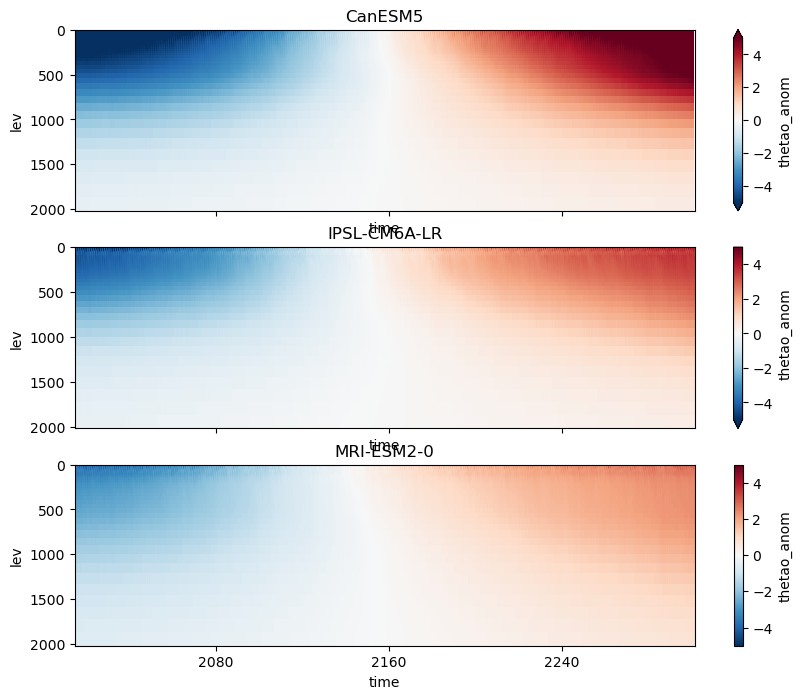

In [78]:
CanESM_40Sssp585= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CanESM5_ssp585_r1i1p1f1_201501-230012.nc',use_cftime=True)
IPSL_40Sssp585= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_IPSL-CM6A-LR_ssp585_r1i1p1f1_201501-230012.nc',use_cftime=True)
MRI_40Sssp585= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_201501-230012.nc',use_cftime=True)
CESM2_40Sssp585= xr.open_dataarray('/g/data/e14/ic0706/ScenarioMIP_SO/lev_regrid/thetao_40S_area_mean_Omon_CESM2-WACCM_ssp585_r1i1p1f1_201501-229912.nc',use_cftime=True)

datasets = [('CanESM5', find_anoms(CanESM_40Sssp585)), ('IPSL-CM6A-LR', find_anoms(IPSL_40Sssp585)), ('MRI-ESM2-0', find_anoms(MRI_40Sssp585)),('CESM2_WACCM',find_anoms(CESM2_40Sssp585))]


fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for ax, (name, ds) in zip(axes, datasets):
    ds.sel(time = slice('2015','2300')).plot(
        x='time', y='lev', ax=ax, cmap='RdBu_r', add_colorbar=True,vmin = -5, vmax = 5
    )
    ax.set_title(name)
    ax.invert_yaxis()


### search for areacello files

In [3]:
# find vocello file for weighted avgs
# === Params  ===
BASE      = "/g/data/oi10/replicas/CMIP6/CMIP/"
# INSTITUTE = ""
MODEL = "CESM2-WACCM"
SCENARIO  = "*"    
MEMBER_GLOB = "*" 
VERSION = "*"
TAIL      =  "*"   # 230012 - check model goes to 2300
SAVE_TXT  = ""  # e.g., "/g/data/oi10/ic0706/matches.txt" to save; leave "" to skip
# ===========================

pattern = str(
    Path(BASE) / "*" / MODEL / SCENARIO / MEMBER_GLOB / "*" / "areacello" / "gn" / VERSION / f"*{TAIL}"
)
print("Searching pattern:\n", pattern)

matches = []
for p in glob.iglob(pattern):
    if os.path.isfile(p):
        matches.append(os.path.realpath(p))

matches = sorted(matches)

print(f"\nFound {len(matches)} file(s).")
for m in matches:
    print(m)

if SAVE_TXT:
    with open(SAVE_TXT, "w") as f:
        f.write("\n".join(matches))
    print(f"\nSaved {len(matches)} path(s) to: {SAVE_TXT}")

Searching pattern:
 /g/data/oi10/replicas/CMIP6/CMIP/*/CESM2-WACCM/*/*/*/areacello/gn/*/**

Found 3 file(s).
/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2-WACCM/1pctCO2/r1i1p1f1/Ofx/areacello/gn/v20190425/areacello_Ofx_CESM2-WACCM_1pctCO2_r1i1p1f1_gn.nc
/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2-WACCM/abrupt-4xCO2/r1i1p1f1/Ofx/areacello/gn/v20190425/areacello_Ofx_CESM2-WACCM_abrupt-4xCO2_r1i1p1f1_gn.nc
/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2-WACCM/piControl/r1i1p1f1/Ofx/areacello/gn/v20190320/areacello_Ofx_CESM2-WACCM_piControl_r1i1p1f1_gn.nc
